In [1]:
import os, requests_oauthlib, flickrapi
from IPython import display

In [2]:
api_key = os.environ.get('FLICKR_KEY')
api_secret = os.environ.get('FLICKR_SECRET')
api_key

'fb5239d737a0070a19d065876c29ba42'

## Authentication (not needed)

In [8]:
request_token_url = 'https://www.flickr.com/services/oauth/request_token'
access_token_url = 'https://www.flickr.com/services/oauth/access_token'
authorization_url = 'https://www.flickr.com/services/oauth/authorize'

In [10]:
sess = requests_oauthlib.OAuth1Session(client_key=api_key, client_secret=api_secret,
    signature_method=u'HMAC-SHA1', signature_type=u'AUTH_HEADER',
    callback_uri='oob')

In [11]:
request_token = sess.fetch_request_token(request_token_url)
oauth_token = request_token.get('oauth_token')
oauth_token_secret = request_token.get('oauth_token_secret')
print('token='+oauth_token)
print('token_secret='+oauth_token_secret)

token=72157677203883132-c21a3251c4023b78
token_secret=0f31a0451e3bf80a


In [12]:
print (sess.authorization_url(authorization_url))

https://www.flickr.com/services/oauth/authorize?oauth_token=72157677203883132-c21a3251c4023b78


In [14]:
verifier = '431-914-645'

In [16]:
auth_sess = requests_oauthlib.OAuth1Session(api_key,
  client_secret=api_secret, resource_owner_key=oauth_token,
  resource_owner_secret=oauth_token_secret, verifier=verifier)

In [17]:
acc_tokens = auth_sess.fetch_access_token(access_token_url)

In [20]:
acc_oauth_token = acc_tokens.get('oauth_token')
acc_oauth_token_secret = acc_tokens.get('oauth_token_secret')
print('acc_oauth_token='+acc_oauth_token)
print('acc_oauth_token_secret='+acc_oauth_token_secret)

acc_oauth_token=72157679188248685-b96a54b36dfd0e15
acc_oauth_token_secret=f63c5f7ce7a85e70


In [21]:
acc_oauth_token='72157679188248685-b96a54b36dfd0e15'
acc_oauth_token_secret='f63c5f7ce7a85e70'

In [22]:
auth_sess = requests_oauthlib.OAuth1Session(api_key,
  client_secret=api_secret, resource_owner_key=acc_oauth_token,
  resource_owner_secret=acc_oauth_token_secret)

## Use API

In [3]:
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='parsed-json')

In [4]:
extras='url_t,url_s,url_m,url_n,url_z,url_c,tags,machine_tags,o_dims,views'

In [5]:
def find_photos(params, page=1):
    return flickr.photos.search(**params, per_page='500', extras=extras, page=page, 
                                media='photo')

In [52]:
from datetime import datetime
import random, requests
import pandas as pd
from concurrent import futures

In [53]:
def get_rand_timestamp():
    # returns a random timestamp between 1/1/2007 and 1/1/2017, as a way to randomly choose photos
    return random.randint(datetime(2007, 1, 1).timestamp(), datetime(2017, 1, 1).timestamp())

In [54]:
data_dict = {}

In [55]:
def get_photo(p):
    data_dict[p['id']] = p
    img_data = requests.get(p['url_s']).content
    filename = 'images/flickr/' + p['id'] + '.jpg'
    with open(filename, 'wb') as handler:
        handler.write(img_data)

Parallelized calls to Flickr API to download photos and their meta data from 10 randomly chosen time ranges

In [56]:
%%time
for n in range(10):
    timestamp = get_rand_timestamp()
    resp = find_photos({'min_taken_date': timestamp, 'max_taken_date': timestamp + 5})
    photos = resp['photos']['photo']
    with futures.ThreadPoolExecutor(16) as exec:
        tasks = [exec.submit(get_photo, p) for p in photos]
        futures.wait(tasks)
    print(n)

0
1
2
3
4
5
6
7
8
9
CPU times: user 1min 45s, sys: 4.41 s, total: 1min 50s
Wall time: 2min 33s


Store the meta data for the photos in a DataFrame, with index as the photo id.  Pickle this dataframe

In [57]:
df = pd.DataFrame.from_dict(data_dict, orient='index')

In [59]:
df.shape

(4498, 32)

In [63]:
pickle_path = "flickr_meta_data.p"
df.to_pickle(pickle_path)

Test that we can load pickled file as expected

In [64]:
df2 = pd.read_pickle(pickle_path)

In [69]:
df2.head()

,width_m,url_s,isfriend,width_n,width_t,o_width,ispublic,isfamily,url_t,url_m,...,title,height_m,height_s,server,farm,url_z,o_height,height_c,url_c,width_c
10034322894,500,https://farm4.staticflickr.com/3718/1003432289...,0,320,100,NaN,1,0,https://farm4.staticflickr.com/3718/1003432289...,https://farm4.staticflickr.com/3718/1003432289...,...,364-Empire State Building,333,160,3718,4,https://farm4.staticflickr.com/3718/1003432289...,NaN,534,https://farm4.staticflickr.com/3718/1003432289...,800
10054729026,500,https://farm6.staticflickr.com/5539/1005472902...,0,320,100,NaN,1,0,https://farm6.staticflickr.com/5539/1005472902...,https://farm6.staticflickr.com/5539/1005472902...,...,IMG_3661,375,180,5539,6,https://farm6.staticflickr.com/5539/1005472902...,NaN,600,https://farm6.staticflickr.com/5539/1005472902...,800
10061552514,332,https://farm6.staticflickr.com/5329/1006155251...,0,213,66,NaN,1,0,https://farm6.staticflickr.com/5329/1006155251...,https://farm6.staticflickr.com/5329/1006155251...,...,Ebrington Arms pub (2),500,240,5329,6,https://farm6.staticflickr.com/5329/1006155251...,NaN,800,https://farm6.staticflickr.com/5329/1006155251...,531
10061617566,500,https://farm3.staticflickr.com/2860/1006161756...,0,320,100,NaN,1,0,https://farm3.staticflickr.com/2860/1006161756...,https://farm3.staticflickr.com/2860/1006161756...,...,Ebrington Arms pub (3),334,160,2860,3,https://farm3.staticflickr.com/2860/1006161756...,NaN,534,https://farm3.staticflickr.com/2860/1006161756...,800
10069471644,500,https://farm8.staticflickr.com/7329/1006947164...,0,320,100,NaN,1,0,https://farm8.staticflickr.com/7329/1006947164...,https://farm8.staticflickr.com/7329/1006947164...,...,Summer Vacation 2013 (part 1) 783,315,151,7329,8,https://farm8.staticflickr.com/7329/1006947164...,NaN,505,https://farm8.staticflickr.com/7329/1006947164...,800


In [68]:
df2.shape

(4498, 32)

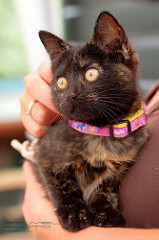

In [87]:
display.Image(p['url_s'])

## End